In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

In [2]:
data = pd.read_csv('data_preprocessed_with_labels.csv')
data

,original_text,processed_text,cyberbullying_score,cyberbullying_word_count,label
0,Mending plonga plong Tinimbang pinter go minteri,mending bingung plong timbang pintar go minteri,0.0,0,0
1,Hidup amin Raiso bapa repormasi,hidup raiso bapa repormasi,0.0,0,0
2,Mantaappps... Btlllll pak...,mantaps btl,0.0,0,0
3,Yang menghina itu lambemu min,menghina itu lambe min,0.0,0,0
4,Amin rais manusia paling redah pikiranya..peng...,manusia redah pikiranya abdi hawa nafsu iri de...,0.0,0,0
...,...,...,...,...,...
18770,@kompascom Tapi aiman bertanya ke pengacaranya...,aiman acara ijazah edar pegang arti ini lindun...,0.0,0,0
18771,@muannas_alaidid Yg jelas omongannya Jokowi pa...,omong palsu titik,0.0,0,0
18772,@CakKhum depresi si om Jokowi,depresi si om,0.0,0,0
18773,@TriSartopo @ch_chotimah2 @jokowi Mana berani ...,berani tatut hm maklum curut berani cuap aja y...,0.0,0,0


In [3]:
vocab_size = 1000
embedding_dim = 16
max_length = 120
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

In [4]:
sentences = data['processed_text']
labels = data['label']

In [6]:
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

train_size = int(len(sentences) * train_ratio)
val_size = int(len(sentences) * val_ratio)
test_size = len(sentences) - train_size - val_size
train_sentences = sentences[:train_size]
val_sentences = sentences[train_size : train_size + val_size]
test_sentences = sentences[train_size + val_size :]
train_labels = labels[:train_size]
val_labels = labels[train_size : train_size + val_size]
test_labels = labels[train_size + val_size :]

In [7]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)
training_sequences = tokenizer.texts_to_sequences(train_sentences)
validation_sequences = tokenizer.texts_to_sequences(val_sentences)
test_sequences = tokenizer.texts_to_sequences(test_sentences)

In [8]:
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [9]:
train_labels = np.array(train_labels)
validation_labels = np.array(val_labels)
test_labels = np.array(test_labels)

In [16]:
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
print(f"Bobot kelas yang dihitung (array): {class_weights_array}")
class_weight_dict = dict(zip(np.unique(train_labels), class_weights_array))
print(f"Bobot kelas dalam format dictionary: {class_weight_dict}")

Bobot kelas yang dihitung (array): [0.43298629 1.26560092 1.31157685 7.25275938]
Bobot kelas dalam format dictionary: {0: 0.43298629414865575, 1: 1.2656009244992297, 2: 1.3115768463073851, 3: 7.252759381898454}


In [17]:
model = tf.keras.models.Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    Bidirectional(LSTM(units=64)),
    Dropout(0.5),
    Dense(units=len(np.unique(train_labels)), activation='softmax')
])
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

epochs = 30
batch_size = 64

history = model.fit(
    training_padded,
    train_labels,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(validation_padded, validation_labels),
    class_weight=class_weight_dict,
    verbose=2
)

/Users/fikrifaizzulfadhli/Python Projects/Python Interpreter/Python 3.12/.venv/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2025-06-05 00:08:36.909314: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4
2025-06-05 00:08:36.909633: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-06-05 00:08:36.909702: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-06-05 00:08:36.909951: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-06-05 00:08:36.910466: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (dev

Epoch 1/30


2025-06-05 00:08:37.656965: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


206/206 - 14s - 66ms/step - accuracy: 0.4782 - loss: 1.2167 - val_accuracy: 0.6939 - val_loss: 0.8532
Epoch 2/30
206/206 - 10s - 48ms/step - accuracy: 0.7779 - loss: 0.7293 - val_accuracy: 0.8615 - val_loss: 0.4346
Epoch 3/30
206/206 - 10s - 49ms/step - accuracy: 0.8828 - loss: 0.4640 - val_accuracy: 0.9400 - val_loss: 0.2609
Epoch 4/30
206/206 - 10s - 49ms/step - accuracy: 0.9502 - loss: 0.2755 - val_accuracy: 0.9237 - val_loss: 0.2801
Epoch 5/30
206/206 - 10s - 50ms/step - accuracy: 0.9664 - loss: 0.2057 - val_accuracy: 0.9663 - val_loss: 0.1255
Epoch 6/30
206/206 - 10s - 50ms/step - accuracy: 0.9768 - loss: 0.1653 - val_accuracy: 0.9648 - val_loss: 0.1267
Epoch 7/30
206/206 - 10s - 48ms/step - accuracy: 0.9817 - loss: 0.1386 - val_accuracy: 0.9705 - val_loss: 0.1199
Epoch 8/30
206/206 - 10s - 49ms/step - accuracy: 0.9848 - loss: 0.1215 - val_accuracy: 0.9759 - val_loss: 0.1029
Epoch 9/30
206/206 - 10s - 49ms/step - accuracy: 0.9835 - loss: 0.1157 - val_accuracy: 0.9734 - val_loss: 0

In [18]:
loss, accuracy = model.evaluate(test_padded, test_labels)
print(f"\nTest Accuracy: {accuracy:.4f}")

89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.9733 - loss: 0.1197

Test Accuracy: 0.9709


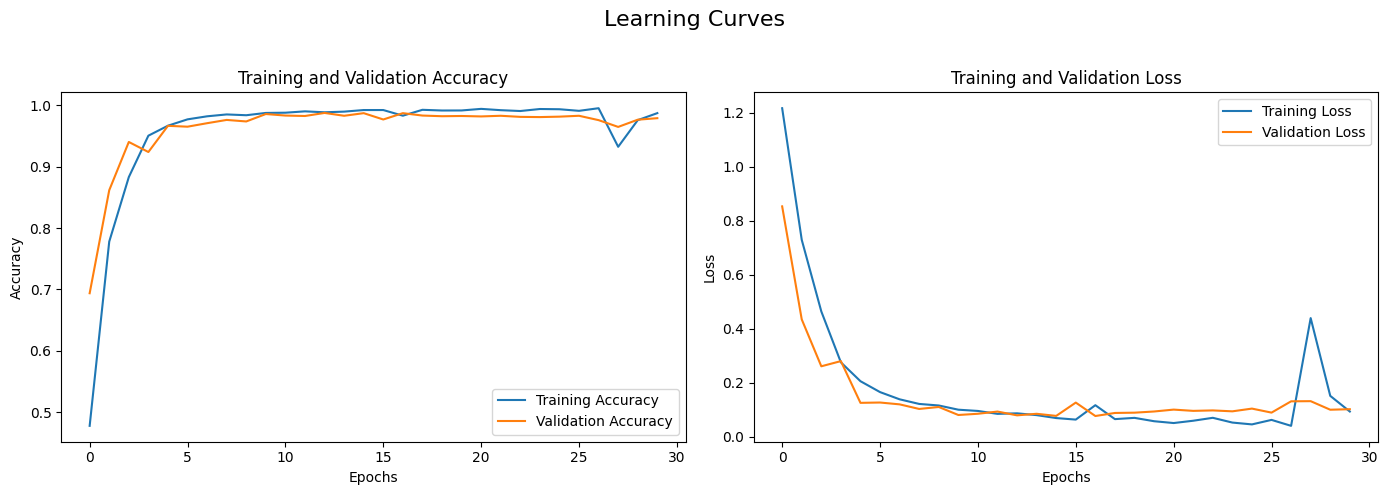

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.suptitle('Learning Curves', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()